In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import ndimage
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.colors as pltc
from dext.postprocessing.detection_visualization import get_text_origin
import colorsys
import random
from matplotlib import gridspec

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('text', usetex=True)
plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=2) # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath \usepackage{bm} \usepackage{amsmath}'

In [18]:
efficientdet_dir1 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/EFFICIENTDETD0_GuidedBackpropagation_random0'
efficientdet_dir2 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/EFFICIENTDETD0_GuidedBackpropagation_random25'
efficientdet_dir3 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/EFFICIENTDETD0_GuidedBackpropagation_random50'
efficientdet_dir4 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/EFFICIENTDETD0_GuidedBackpropagation_random75'
efficientdet_dir5 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/EFFICIENTDETD0_GuidedBackpropagation_random100'

ssd_dir1 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/SSD512_GuidedBackpropagation_random0'
ssd_dir2 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/SSD512_GuidedBackpropagation_random25'
ssd_dir3 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/SSD512_GuidedBackpropagation_random50'
ssd_dir4 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/SSD512_GuidedBackpropagation_random75'
ssd_dir5 = '/media/deepan/externaldrive1/project_repos/DEXT_versions/dext/images/results_random/SSD512_GuidedBackpropagation_random100'

saliency_image_paths = 'saliency_image_paths'
coco_dataset_path = '/media/deepan/externaldrive1/datasets_project_repos/coco/test2017/'
result_path_pattern_old = ''
result_path_pattern_new = ''


In [19]:
def get_history_file(result_dir, filename):
    if os.path.exists(result_dir):
        file = os.path.join(result_dir, filename)
        if os.path.exists(file):
            return file
        else:
            raise ValueError('File in directory unavailable') 
    else:
        raise ValueError('Result directory unavailable')

def get_image_index_counts(result_dir, filename):
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    data = np.array(data)
    all_image_index = list(np.unique(data[:, 0]))
    return len(all_image_index)

def get_data(result_dir, filename):
    model_name_interpretation = (result_dir.split('/')[-1])
    model_name = model_name_interpretation.split('_')[0]
    interpretation_method = model_name_interpretation.split('_')[1]
    print('Model name: %s | Interpretation method: %s' % (model_name, interpretation_method))
    print("Number of saliency image paths: ", get_image_index_counts(result_dir, saliency_image_paths))
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    return np.array(data)

In [20]:
def read_image(filepath):
    print("Reading image file: ", filepath)
    raw_image = cv2.imread(filepath)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(raw_image, (512, 512))
    return raw_image, image

def clean_data(data, file_path_avail, file_path_replacement):
    for i in data:
        temp = i[-2]
        temp = temp.replace(file_path_avail, file_path_replacement)
        i[-2] = temp
    return data

def rescale_box(box, old_size, new_size):
    image_h, image_w, _ = old_size
    new_h, new_w = new_size
    x_min, y_min, x_max, y_max = box
    x_min = max(0, int((x_min / image_w) * new_w))
    y_min = max(0, int((y_min / image_h) * new_h))
    x_max = min(int((x_max / image_w) * new_w), new_w)
    y_max = min(int((y_max / image_h) * new_h), new_h)
    return x_min, y_min, x_max, y_max

def plot_bbox(box, edge_color, ax):
    if not ax:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot()
    x_min, y_min, x_max, y_max = box     
    rect = Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=1, edgecolor=edge_color,
                    facecolor='none', alpha=0.7)
    ax.add_patch(rect)
    
def plot_text(text, box, edge_color, ax, fontsize=12):
    props = dict(edgecolor='none', facecolor='none', boxstyle='square')   
    ax.text(box[0], box[3]-10, text, color='white', bbox=props, fontsize=fontsize, clip_on=True, wrap=True)

In [21]:
def get_heatmaps(data, model_name):
    class_maps = []
    box_maps1 = []
    box_maps2 = []
    box_maps3 = []
    box_maps4 = []
    class_maps_boxes = []
    box_maps1_boxes = []
    box_maps2_boxes = []
    box_maps3_boxes = []
    box_maps4_boxes = []
    labels = []
    for i in data:
        if i[5] == 'Classification':
            class_maps.append(np.load(i[-2]))
            class_maps_boxes.append(i[2])
            labels.append(i[4])
        if 'EFFICIENTDET' in model_name or model_name == 'FasterRCNN':
            if i[5] == 'Boxoffset' and i[6] == 0:
                box_maps2.append(np.load(i[-2]))
                box_maps2_boxes.append(i[2])
            elif i[5] == 'Boxoffset' and i[6] == 1:
                box_maps1.append(np.load(i[-2]))
                box_maps1_boxes.append(i[2])
            elif i[5] == 'Boxoffset' and i[6] == 2:
                box_maps4.append(np.load(i[-2]))
                box_maps4_boxes.append(i[2])
            elif i[5] == 'Boxoffset' and i[6] == 3:
                box_maps3.append(np.load(i[-2]))
                box_maps3_boxes.append(i[2])
        else:
            if i[5] == 'Boxoffset' and i[6] == 0:
                box_maps1.append(np.load(i[-2]))
                box_maps1_boxes.append(i[2])
            elif i[5] == 'Boxoffset' and i[6] == 1:
                box_maps2.append(np.load(i[-2]))
                box_maps2_boxes.append(i[2])
            elif i[5] == 'Boxoffset' and i[6] == 2:
                box_maps3.append(np.load(i[-2]))
                box_maps3_boxes.append(i[2])
            elif i[5] == 'Boxoffset' and i[6] == 3:
                box_maps4.append(np.load(i[-2]))
                box_maps4_boxes.append(i[2])
    data = {}        
    data['class_maps'] = class_maps
    data['class_maps_boxes'] = class_maps_boxes
    data['box_maps1'] = box_maps1
    data['box_maps1_boxes'] = box_maps1_boxes
    data['box_maps2'] = box_maps2
    data['box_maps2_boxes'] = box_maps2_boxes
    data['box_maps3'] = box_maps3
    data['box_maps3_boxes'] = box_maps3_boxes
    data['box_maps4'] = box_maps4
    data['box_maps4_boxes'] = box_maps4_boxes
    data['labels'] = labels
    return data

In [22]:
efficientdet_data1 = get_data(efficientdet_dir1, saliency_image_paths)
efficientdet_data2 = get_data(efficientdet_dir2, saliency_image_paths)
efficientdet_data3 = get_data(efficientdet_dir3, saliency_image_paths)
efficientdet_data4 = get_data(efficientdet_dir4, saliency_image_paths)
efficientdet_data5 = get_data(efficientdet_dir5, saliency_image_paths)

ssd_data1 = get_data(ssd_dir1, saliency_image_paths)
ssd_data2 = get_data(ssd_dir2, saliency_image_paths)
ssd_data3 = get_data(ssd_dir3, saliency_image_paths)
ssd_data4 = get_data(ssd_dir4, saliency_image_paths)
ssd_data5 = get_data(ssd_dir5, saliency_image_paths)

Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: SSD512 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: SSD512 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: SSD512 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: SSD512 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  1
Model name: SSD512 | Interpretation method: GuidedB

/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [23]:
# Find unique image ids
column_names = ['image_index', 'object_index', 'box', 'confidence', 'class', 'explaining',
                'boxoffset', 'saliency_path', 'image_path']
count_image_index = np.unique(efficientdet_data1[:, column_names.index('image_index')], return_counts=True)
count_image_index

(array(['162701'], dtype=object), array([5]))

In [24]:
# Select image index to draw images
efficientdet_ex1_data = efficientdet_data1[efficientdet_data1[:,column_names.index('image_index')] == '162701']
efficientdet_ex1_data = clean_data(efficientdet_ex1_data, result_path_pattern_old, result_path_pattern_new)
efficientdet_ex1_image = read_image(filepath=os.path.join(coco_dataset_path, efficientdet_ex1_data[0][-1].split('/')[-1]))   
efficientdet_ex1_map_dict = get_heatmaps(efficientdet_ex1_data, 'EFFICIENTDETD0')

# Select image index to draw images
efficientdet_ex2_data = efficientdet_data2[efficientdet_data2[:,column_names.index('image_index')] == '162701']
efficientdet_ex2_data = clean_data(efficientdet_ex2_data, result_path_pattern_old, result_path_pattern_new)
efficientdet_ex2_image = read_image(filepath=os.path.join(coco_dataset_path, efficientdet_ex2_data[0][-1].split('/')[-1]))   
efficientdet_ex2_map_dict = get_heatmaps(efficientdet_ex2_data, 'EFFICIENTDETD0')

# Select image index to draw images
efficientdet_ex3_data = efficientdet_data3[efficientdet_data3[:,column_names.index('image_index')] == '162701']
efficientdet_ex3_data = clean_data(efficientdet_ex3_data, result_path_pattern_old, result_path_pattern_new)
efficientdet_ex3_image = read_image(filepath=os.path.join(coco_dataset_path, efficientdet_ex3_data[0][-1].split('/')[-1]))   
efficientdet_ex3_map_dict = get_heatmaps(efficientdet_ex3_data, 'EFFICIENTDETD0')

# Select image index to draw images
efficientdet_ex4_data = efficientdet_data4[efficientdet_data4[:,column_names.index('image_index')] == '162701']
efficientdet_ex4_data = clean_data(efficientdet_ex4_data, result_path_pattern_old, result_path_pattern_new)
efficientdet_ex4_image = read_image(filepath=os.path.join(coco_dataset_path, efficientdet_ex4_data[0][-1].split('/')[-1]))   
efficientdet_ex4_map_dict = get_heatmaps(efficientdet_ex4_data, 'EFFICIENTDETD0')

# Select image index to draw images
efficientdet_ex5_data = efficientdet_data5[efficientdet_data5[:,column_names.index('image_index')] == '162701']
efficientdet_ex5_data = clean_data(efficientdet_ex5_data, result_path_pattern_old, result_path_pattern_new)
efficientdet_ex5_image = read_image(filepath=os.path.join(coco_dataset_path, efficientdet_ex5_data[0][-1].split('/')[-1]))   
efficientdet_ex5_map_dict = get_heatmaps(efficientdet_ex5_data, 'EFFICIENTDETD0')

Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg


In [26]:
# Select image index to draw images
ssd_ex1_data = ssd_data1[ssd_data1[:,column_names.index('image_index')] == '162701']
ssd_ex1_data = clean_data(ssd_ex1_data, result_path_pattern_old, result_path_pattern_new)
ssd_ex1_image = read_image(filepath=os.path.join(coco_dataset_path, ssd_ex1_data[0][-1].split('/')[-1]))   
ssd_ex1_map_dict = get_heatmaps(ssd_ex1_data, 'SSD512')

# Select image index to draw images
ssd_ex2_data = ssd_data2[ssd_data2[:,column_names.index('image_index')] == '162701']
ssd_ex2_data = clean_data(ssd_ex2_data, result_path_pattern_old, result_path_pattern_new)
ssd_ex2_image = read_image(filepath=os.path.join(coco_dataset_path, ssd_ex2_data[0][-1].split('/')[-1]))   
ssd_ex2_map_dict = get_heatmaps(ssd_ex2_data, 'SSD512')

# Select image index to draw images
ssd_ex3_data = ssd_data3[ssd_data3[:,column_names.index('image_index')] == '162701']
ssd_ex3_data = clean_data(ssd_ex3_data, result_path_pattern_old, result_path_pattern_new)
ssd_ex3_image = read_image(filepath=os.path.join(coco_dataset_path, ssd_ex3_data[0][-1].split('/')[-1]))   
ssd_ex3_map_dict = get_heatmaps(ssd_ex3_data, 'SSD512')

# Select image index to draw images
ssd_ex4_data = ssd_data4[ssd_data4[:,column_names.index('image_index')] == '162701']
ssd_ex4_data = clean_data(ssd_ex4_data, result_path_pattern_old, result_path_pattern_new)
ssd_ex4_image = read_image(filepath=os.path.join(coco_dataset_path, ssd_ex4_data[0][-1].split('/')[-1]))   
ssd_ex4_map_dict = get_heatmaps(ssd_ex4_data, 'SSD512')

# Select image index to draw images
ssd_ex5_data = ssd_data5[ssd_data5[:,column_names.index('image_index')] == '162701']
ssd_ex5_data = clean_data(ssd_ex5_data, result_path_pattern_old, result_path_pattern_new)
ssd_ex5_image = read_image(filepath=os.path.join(coco_dataset_path, ssd_ex5_data[0][-1].split('/')[-1]))   
ssd_ex5_map_dict = get_heatmaps(ssd_ex5_data, 'SSD512')

Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg
Reading image file:  /media/deepan/externaldrive1/datasets_project_repos/coco/test2017/000000162701.jpg


/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


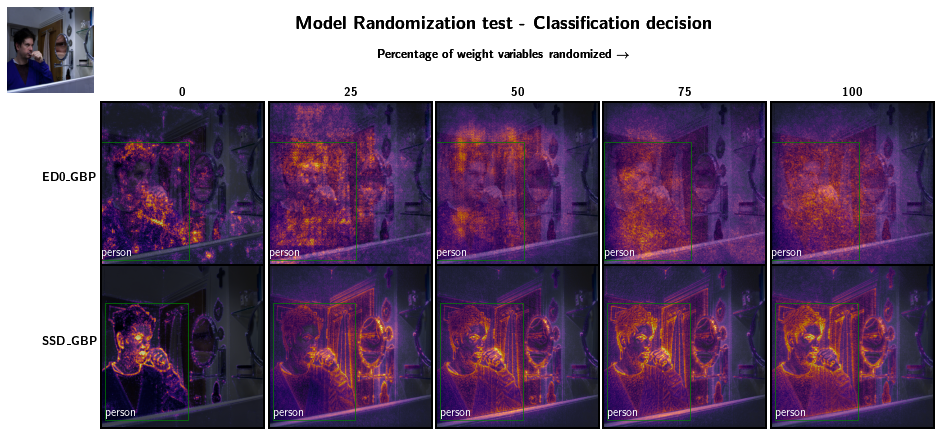

In [93]:
num_examples_to_explain = 5
num_rows = 2
num_columns = num_examples_to_explain

explain_data = [[efficientdet_ex1_map_dict, efficientdet_ex2_map_dict, efficientdet_ex3_map_dict, efficientdet_ex4_map_dict, efficientdet_ex5_map_dict], 
                [ssd_ex1_map_dict, ssd_ex2_map_dict, ssd_ex3_map_dict, ssd_ex4_map_dict, ssd_ex5_map_dict],
#                 [fasterrcnn_ex1_map_dict, fasterrcnn_ex2_map_dict, fasterrcnn_ex3_map_dict]
               ]

explain_image = [[efficientdet_ex1_image],
                 [ssd_ex1_image],
#                  [fasterrcnn_ex1_image, fasterrcnn_ex2_image, fasterrcnn_ex3_image]
                ]

visualize_detection = [[0],
                       [0],
#                        [1]
                      ]
explain = 'Classification'
row_titles = [r'\textbf{ED0\_GBP}', r'\textbf{SSD\_GBP}', r'\textbf{FRCNN\_GBP}']
col_titles = [r'\textbf{0}', r'\textbf{25}', r'\textbf{50}', r'\textbf{75}', r'\textbf{100}']
count = 0

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(num_rows, num_columns, wspace=0, hspace=0)

for i in range(num_rows):
    for j in range(num_columns):
        raw_image = explain_image[i][0][0]
        image = explain_image[i][0][1]
        maps = explain_data[i][j]['class_maps'][visualize_detection[i][0]]
        box = explain_data[i][j]['class_maps_boxes'][visualize_detection[i][0]]
        box = rescale_box(box, raw_image.shape, maps.shape)
        x_min, y_min, x_max, y_max = box
        
        labels = explain_data[i][j]['labels'][visualize_detection[i][0]]
               
        ax = plt.subplot(gs[i, j])
        ax.imshow(maps, cmap='inferno')
        ax.imshow(image, alpha=0.3)
        plot_bbox(box, 'green', ax)
        plot_text(labels, box, 'green', ax)
        ax.set_xticks([])
        ax.set_yticks([])
        if count < num_columns:
            ax.set_title(col_titles[count], fontsize=12)
        count = count + 1
        if ax.is_first_col():
            ax.set_ylabel(row_titles[i], fontsize=12, rotation='horizontal', ha='right')
    title1 = r'\textbf{Model Randomization test - Classification decision}'
    title2 =  r'\textbf{Percentage of weight variables randomized $\rightarrow$}'
    plt.text(x=0.5, y=1.05, s=title1, fontsize=18, ha="center", transform=fig.transFigure)
    plt.text(x=0.5, y=0.98, s=title2, fontsize=12, ha="center", transform=fig.transFigure)
    newax = fig.add_axes([-0.08, 0.9, 0.2, 0.2], anchor='NE', zorder=-1)
    newax.imshow(efficientdet_ex1_image[1])
    newax.axis('off')
fig.savefig('pdf_images/randomization_new.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
fig.clear()
plt.close(fig)
fig.clf()        